In [1]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))

import torch
iscuda = torch.cuda.is_available()
cuda = torch.cuda.is_available()


from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import ToTensor
from functools import reduce
import pandas as pd
from nltk import sent_tokenize, word_tokenize
from torch.nn.utils.rnn import pad_sequence

import io

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchtext import data as t_data

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
LoTR = True

if LoTR==True:
    p1 = io.open("Data\LoTR\The Lord Of The Ring 1-The Fellowship Of The Ring_djvu.txt","r", encoding='utf8').read()
    p2 = io.open("Data\LoTR\The Lord Of The Ring 2-The Two Towers_djvu.txt","r",encoding='utf8').read()
    p3 = io.open("Data\LoTR\The Return Of The King_djvu.txt","r", encoding='utf8').read()
else:
    p1 = io.open("Data\PoE\4ggNLmuc.txt","r", encoding='utf8').read()
    p2 = io.open("Data\PoE\pathofexile_3.8_patch_notes.txt","r",encoding='utf8').read()
    p3 = io.open("Data\PoE\poe_3.7_patch_notes.txt","r", encoding='utf8').read()
dataset = p1.split("\n")# + p2.split("\n") + p3.split("\n")
# Only using the first LotR story, add p2 and p3 for the other two, and change LotR to False for patch notes

In [4]:
dataset = dataset[1000:2500]


# This can be used to reduce the size of the dataset used, if testing, it is recommended to start at 
# around 500-2000 entries from the middle of the story


In [5]:
# This is used  to normalize the words 
sentences = []
for d in dataset:
    test = word_tokenize(d)
    
    full_sent = ' '.join(test)
    token_sent = sent_tokenize(full_sent)

    sentences = sentences + token_sent

In [6]:
# This is used to find all unique words

sequences = []
for d in sentences:
    words = d.split(' ')
    sequences.extend(words)


In [7]:
every_word = set()

for word in sequences:
    every_word.add(word.lower())


In [8]:
from collections import defaultdict

# This is used to find all unique tokens of words and associate them with indices. Based on the work from course notebooks

def sequences_to_dicts(sequences):
    """
    Creates word_to_idx and idx_to_word dictionaries for a list of sequences.
    """
    
    
    # A bit of Python-magic to flatten a nested list
    flatten = lambda l: [item for sublist in l for item in sublist]
    
    # Flatten the dataset
    all_words = flatten(sequences)
    
    # Count number of word occurences
    word_count = defaultdict(int)
    for word in flatten(sequences):
        word_count[word] += 1

    # Sort by frequency
    word_count = sorted(list(word_count.items()), key=lambda l: -l[1])

    # Create a list of all unique words
    unique_words = [item[0] for item in word_count]
    
    # Add UNK token to list of words
    unique_words.append('UNK')

    unique_words.append(' ')
    unique_words.append('\"')

    every_word = set()

    for word in sequences:
        every_word.add(word.lower())
    
    every_word.add('UNK')

    unique_words = every_word
    
    # Count number of sequences and number of unique words
    num_sentences, vocab_size = len(sequences), len(unique_words)

    # Create dictionaries so that we can go from word to index and back
    # If a word is not in our vocabulary, we assign it to token 'UNK'
    word_to_idx = defaultdict(lambda: num_sentences)
    idx_to_word = defaultdict(lambda: 'UNK')

    # Fill dictionaries
    for idx, word in enumerate(unique_words):
        word_to_idx[word] = idx 
        idx_to_word[idx] = word 

    return word_to_idx, idx_to_word, num_sentences, vocab_size


word_to_idx, idx_to_word, num_sequences, vocab_size = sequences_to_dicts(sequences)

print(f'We have {num_sequences} words and {len(word_to_idx)} unique tokens in our dataset (including UNK).\n')
print('The index of \'the\' is', word_to_idx['the'])
print(f'The word corresponding to index 1 is \'{idx_to_word[1]}\'')

We have 15508 words and 2480 unique tokens in our dataset (including UNK).

The index of 'the' is 2234
The word corresponding to index 1 is 'disliking'


In [9]:
# Assemble one-hot encoding for the vocabulary

def one_hot_encode(idx, vocab_size):
    """
    One-hot encodes a single word given its index and the size of the vocabulary.
    
    Args:
     `idx`: the index of the given word
     `vocab_size`: the size of the vocabulary
    
    Returns a 1-D numpy array of length `vocab_size`.
    """
    # Initialize the encoded array
    one_hot = np.zeros(vocab_size)
    
    # Set the appropriate element to one
    one_hot[idx] = 1.0

    return one_hot


def one_hot_encode_sequence(sequence, vocab_size):
    """
    One-hot encodes a sequence of words given a fixed vocabulary size.
    
    Args:
     `sentence`: a list of words to encode
     `vocab_size`: the size of the vocabulary
     
    Returns a 3-D numpy array of shape (num words, vocab size, 1).
    """
    
    # Encode each word in the sentence
    encoding = np.array([one_hot_encode(word_to_idx[word.lower()], vocab_size) for word in sequence])

    # Reshape encoding s.t. it has shape (num words, vocab size, 1)
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    
    return encoding


test_word = one_hot_encode(word_to_idx['the'], vocab_size)
print(f'Our one-hot encoding of \'the\' has shape {test_word.shape}.')
print(test_word)


Our one-hot encoding of 'the' has shape (2480,).
[0. 0. 0. ... 0. 0. 0.]


In [10]:
from torch.utils import data
import random


class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y

    
def create_datasets(sequences, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    # Define partition sizes
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)

    random_sequence = sequences
    random.shuffle(random_sequence)
    
    # Split sequences into partitions
    sequences_train = random_sequence[:num_train]
    sequences_val = random_sequence[num_train:num_train+num_val]
    sequences_test = random_sequence[-num_test:]

    def get_inputs_targets_from_sequences(sequences):
        # Define empty lists
        inputs, targets = [], []
        
        # Append inputs and targets s.t. both lists contain L-1 words of a sentence of length L
        # but targets are shifted right by one so that we can predict the next word
        
        for sequence in sequences:
            sequence = sequence.lower()
            sequence_list = sequence.split(' ')
            if len(sequence_list) < 2:
                continue
            
            inputs.append(sequence_list[:-1])
            targets.append(sequence_list[1:])
            
        return inputs, targets

    # Get inputs and targets for each partition
    inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
    inputs_val, targets_val = get_inputs_targets_from_sequences(sequences_val)
    inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)

    # Create datasets
    training_set = dataset_class(inputs_train, targets_train)
    validation_set = dataset_class(inputs_val, targets_val)
    test_set = dataset_class(inputs_test, targets_test)

    return training_set, validation_set, test_set

In [11]:
training_set, validation_set, test_set = create_datasets(sentences, Dataset)

print(f'We have {len(training_set)} samples in the training set.')
print(f'We have {len(validation_set)} samples in the validation set.')
print(f'We have {len(test_set)} samples in the test set.')

We have 1375 samples in the training set.
We have 170 samples in the validation set.
We have 167 samples in the test set.


In [12]:
BATCH_SIZE = 32

In [13]:
train_batches_inputs = []
train_batches_targets = []

train_batches = []

num_batches = int(len(training_set.inputs)/BATCH_SIZE)

for i in range(num_batches):
    train_batches.append((training_set.inputs[i*BATCH_SIZE:(i+1)*BATCH_SIZE], training_set.targets[i*BATCH_SIZE:(i+1)*BATCH_SIZE]))
    
    train_batches_inputs.append(training_set.inputs[i*BATCH_SIZE:(i+1)*BATCH_SIZE])
    train_batches_targets.append(training_set.targets[i*BATCH_SIZE:(i+1)*BATCH_SIZE])

In [14]:
encoder_hidden_dim = 256
linears_dim = encoder_hidden_dim*2

decoder_hidden_dim = 256

embed_reduction_size = 300
hidden_dim = 512

sampler_size = 100

In [15]:
import torch.nn as nn
from torch.nn.functional import softplus

# define size variables
num_features = 300

# This was initially based on the VAE seen in the course notebooks

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_features, num_samples):
        super(VariationalAutoencoder, self).__init__()
        
        self.latent_features = latent_features
        self.num_samples = num_samples
        
        self.lstm = nn.LSTM(input_size = vocab_size, hidden_size = encoder_hidden_dim, num_layers=1, bidirectional = False)

        self.encoder = nn.Sequential(
            nn.Linear(in_features=encoder_hidden_dim, out_features=2*self.latent_features) 
        )
        
        # The latent code must be decoded into the original dimension. Done via a linear layer for this iteration
        self.alt_dec = nn.Linear(in_features=latent_features, out_features=vocab_size)
        

    def forward(self, x): 
        outputs = {}
        
        seq_len, batch_size, _ = x.shape
        
        x, (_, _) = self.lstm(x)
        
        # Split encoder outputs into a mean and variance vector
        testx = self.encoder(x)
        
        mu, log_var = torch.chunk(testx, 2, dim=-1)
        
        # :- Reparametrisation trick
        # a sample from N(mu, sigma) is mu + sigma * epsilon
        # where epsilon ~ N(0, 1)
                
        # Don't propagate gradients through randomness
        with torch.no_grad():
            epsilon = torch.randn(seq_len, batch_size, self.latent_features)
            
            if cuda:
                epsilon = epsilon.cuda()
        
        
        sigma = torch.exp(log_var/2)
        
        z = mu + epsilon * sigma        

        
        # Run through decoder        
        x = self.alt_dec(z)
                
        x = F.log_softmax(x,dim=-1)
        

        # Mean over samples
        x_hat = torch.mean(x, dim=1)

        outputs["x_hat"] = x_hat
        outputs["z"] = z
        outputs["mu"] = mu
        outputs["log_var"] = log_var
        
        return outputs


latent_features = 8
num_samples = 1

net = VariationalAutoencoder(latent_features, num_samples)

# Transfer model to GPU if available
if cuda:
    net = net.cuda()

print(net)

VariationalAutoencoder(
  (lstm): LSTM(2480, 256)
  (encoder): Sequential(
    (0): Linear(in_features=256, out_features=16, bias=True)
  )
  (alt_dec): Linear(in_features=8, out_features=2480, bias=True)
)


In [16]:
#net.load_state_dict(torch.load('net_checkpoint'))
# This can be used to avoid having to retrain the network

In [17]:
from torch.nn.functional import binary_cross_entropy
from torch import optim

def ELBO_loss(y, t, mu, log_var, step):

    
    likelihood = -F.nll_loss(y, t, reduction="none")
    likelihood = likelihood.view(likelihood.size(0), -1).sum(1)

    # Regularization error: 
    # Kulback-Leibler divergence between approximate posterior, q(z|x)
    # and prior p(z) = N(z | mu, sigma*I).
    
    # In the case of the KL-divergence between diagonal covariance Gaussian and 
    # a standard Gaussian, an analytic solution exists. Using this excerts a lower
    # variance estimator of KL(q||p)
    kl = -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1)

    # Combining the two terms in the evidence lower bound objective (ELBO) 
    # mean over batch
    
    k_coef = (np.tanh((step - 40000)/10000) + 1) / 2
    
    ELBO = torch.mean(likelihood) - k_coef*torch.mean(kl)
    
    return -ELBO, kl.sum()


# define our optimizer
# The Adam optimizer works really well with VAEs.
optimizer = optim.Adam(net.parameters(), lr=0.005)
loss_function = ELBO_loss

In [18]:
device = torch.device("cuda:0" if iscuda else "cpu")

In [19]:
from torch.autograd import Variable

# This is a simple test run to see the sizes and initial losses

if iscuda:
    net = net.cuda()

inputs = train_batches[1][0][0]
targets = train_batches[1][1][0]


print(inputs)

inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_idx = [word_to_idx[word] for word in targets]
targets_idx = torch.LongTensor(targets_idx).to(device)

# Convert input to tensor
inputs_one_hot = torch.Tensor(inputs_one_hot).to(device)
inputs_one_hot = inputs_one_hot.permute(0, 2, 1)

outputs = net(inputs_one_hot)

x_hat = outputs["x_hat"]
mu, log_var = outputs["mu"], outputs["log_var"]
z = outputs["z"]

step = 50000

loss, kl = loss_function(x_hat, targets_idx, mu, log_var, step)

print(inputs_one_hot.shape)
print(x_hat.shape)
print(z.shape)
print(loss)
print(kl)

['birthday', 'was', 'drawing', 'near', ':', 'fifty', 'was', 'a', 'number', 'that', 'he', 'felt', 'was']
torch.Size([13, 1, 2480])
torch.Size([13, 2480])
torch.Size([13, 1, 8])
tensor(8.0676, device='cuda:0', grad_fn=<NegBackward>)
tensor(0.1279, device='cuda:0', grad_fn=<SumBackward0>)


In [20]:
import os
from sklearn.decomposition import PCA

num_epochs = 30

train_loss, valid_loss = [], []
train_kl, valid_kl = [], []

device = torch.device("cuda:0" if cuda else "cpu")
print("Using device:", device)

step = 0

for epoch in range(num_epochs):
    batch_loss, batch_kl = [], []
    net.train()
    
    # Go through each batch in the training dataset
    for inputs, targets in training_set:
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_idx = [word_to_idx[word] for word in targets]
        targets_idx = torch.LongTensor(targets_idx).to(device)
        
        # Convert input to tensor
        inputs_one_hot = torch.Tensor(inputs_one_hot).to(device)
        inputs_one_hot = inputs_one_hot.permute(0, 2, 1)

        outputs = net(inputs_one_hot)

        x_hat = outputs["x_hat"]
        mu, log_var = outputs["mu"], outputs["log_var"]
        z = outputs["z"]

        elbo, kl = loss_function(x_hat, targets_idx, mu, log_var, step)
        step+=1
        optimizer.zero_grad()
        elbo.backward()
        optimizer.step()
        
        batch_loss.append(elbo.item())
        batch_kl.append(kl.item())

    train_loss.append(np.mean(batch_loss))
    train_kl.append(np.mean(batch_kl))

    # Evaluate, do not propagate gradients
    with torch.no_grad():
        net.eval()
        
        b_valid_loss, b_valid_kl = [], []
        for inputs, targets in validation_set:
            
            inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
            targets_idx = [word_to_idx[word] for word in targets]
            targets_idx = torch.LongTensor(targets_idx).to(device)
        
            # Convert input to tensor
            inputs_one_hot = torch.Tensor(inputs_one_hot).to(device)
            inputs_one_hot = inputs_one_hot.permute(0, 2, 1)

            outputs = net(inputs_one_hot)

            x_hat = outputs["x_hat"]
            mu, log_var = outputs["mu"], outputs["log_var"]
            z = outputs["z"]

            elbo, kl = loss_function(x_hat, targets_idx, mu, log_var, step)

            b_valid_loss.append(elbo.item())
            b_valid_kl.append(kl.item())
    
        valid_loss.append(np.mean(b_valid_loss))
        valid_kl.append(np.mean(b_valid_kl))
    if epoch == 0:
        continue
    
    if epoch%5 ==0:
        print(epoch)
        print("Train Loss: ", train_loss[-1])
        print("Train KL: ", train_kl[-1])
        print("Valid Loss: ", valid_loss[-1])
        print("Valid KL: ", valid_kl[-1])

Using device: cuda:0
5
Train Loss:  3.1531213853684337
Train KL:  416.18536320495605
Valid Loss:  7.0543924375053715
Valid KL:  367.36221574895524
10
Train Loss:  1.9601199726950038
Train KL:  625.5022483159845
Valid Loss:  9.286398871593615
Valid KL:  430.1344097249648
15
Train Loss:  1.6166235326311804
Train KL:  559.2508087782427
Valid Loss:  10.148322981771301
Valid KL:  353.22818693273206
20
Train Loss:  1.6949020755182613
Train KL:  332.2880272369385
Valid Loss:  9.879606030267828
Valid KL:  207.09671301561244
25
Train Loss:  2.049673229943622
Train KL:  169.53172702858666
Valid Loss:  9.355710514503366
Valid KL:  109.7442940571729


In [247]:
inputs, targets = training_set[61]

net.eval()

init_inputs = inputs.copy()

inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_idx = [word_to_idx[word] for word in targets]
targets_idx = torch.LongTensor(targets_idx).to(device)
        
# Convert input to tensor
inputs_one_hot = torch.Tensor(inputs_one_hot).to(device)
inputs_one_hot = inputs_one_hot.permute(0, 2, 1)

outputs = net(inputs_one_hot)

x_hat = outputs["x_hat"]
mu, log_var = outputs["mu"], outputs["log_var"]
z = outputs["z"]

outputs = x_hat.data.cpu().numpy()


word_idxs = []
for dis in outputs: 
    next_word = dis
    
    floor = min(next_word)
    next_word = [x - floor for x in next_word]
    next_word /= sum(next_word)

    #word_index = np.random.choice(len(next_word), p=next_word)
    # The above statement can be used to use the output vector as a probability distribution for selection of the output word
    # rather than always taking the best option.
    
    word_index = np.argmax(dis)
    word_idxs.append(word_index)


inputstr = ' '.join(init_inputs)

targetstr = ' '.join(targets)

predictedSeq = [idx_to_word[wi] for wi in word_idxs]
teststr = ' '.join(predictedSeq)

print('\nInput sequence:')
print(inputstr)

print('\nTarget sequence:')
print(targetstr)

print('\nPredicted sequence:')
print(teststr)


Input sequence:
and 1418 , he had used all the sources available to him in rivendell ,

Target sequence:
1418 , he had used all the sources available to him in rivendell , both

Predicted sequence:
suddenly , he had used all the spoons - to him in rivendell , both


In [22]:
torch.save(net.state_dict(), 'net_checkpoint_sub2')


In [248]:
# This is used to generate a sentence based on some initial word or phrase. 

count = 0

full_story = 'and'
phrase = [full_story]

while count < 15: # 
    net.eval()
    inputs = phrase
    
    inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)

    # Convert input to tensor
    inputs_one_hot = torch.Tensor(inputs_one_hot).cuda()
    inputs_one_hot = inputs_one_hot.permute(0, 2, 1)


    outputs = net.forward(inputs_one_hot)
    x_hat = outputs["x_hat"]
    mu, log_var = outputs["mu"], outputs["log_var"]
    z = outputs["z"]
    outputs = x_hat.data.cpu().numpy()

    
    next_word = outputs[-1]
    
    #floor = min(next_word)
    #next_word = [x - floor for x in next_word]
    #next_word /= sum(next_word)
    count+=1
    
    # word_index = np.random.choice(len(next_word), p=next_word)
    # The above statement can be used to use the output vector as a probability distribution for selection of the output word
    # rather than always taking the best option.
    word_index = np.argmax(next_word)
    
    
    predictedSeq = idx_to_word[word_index]
    
    
    teststr = ' '.join(predictedSeq)
    full_story += ' ' + predictedSeq
    phrase = full_story.split(' ')

print(full_story)

and why not ? ' he said that . ' a wonder that bilbo 's eleventy-one


In [249]:
valid_trend = valid_loss[::int(len(valid_loss)/num_epochs)]
valid_kl_trend = valid_kl[::int(len(valid_loss)/num_epochs)]
# Used to select only every new epoch

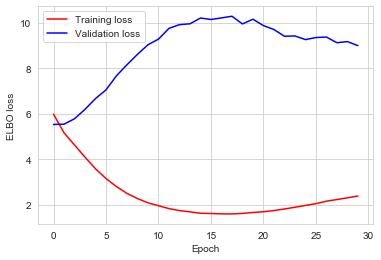

In [250]:
epoch = np.arange(len(valid_trend))
plt.figure()
plt.plot(epoch, train_loss, 'r', label='Training loss',)
plt.plot(epoch, valid_trend, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('ELBO loss')
plt.show()

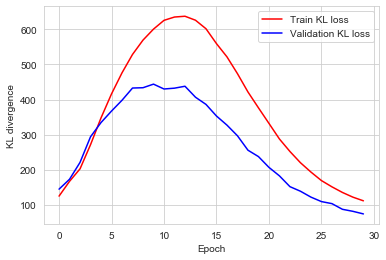

In [251]:
epoch = np.arange(len(valid_trend))
plt.figure()
plt.plot(epoch, train_kl, 'r', label='Train KL loss',)
plt.plot(epoch, valid_kl_trend, 'b', label='Validation KL loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('KL divergence')
plt.show()